In [2]:
import pandas as pd    
import numpy as np
import pickle
from tqdm import tqdm
import lightgbm

from constants import *
from constants_id import *
from indexing import BasicInvertedIndex
from document_preprocessor import RegexTokenizer
from ranker import Ranker, BM25
from l2r_author import L2RFeatureExtractor, L2RRanker
from relevance import map_score, ndcg_score

In [3]:
document_preprocessor = RegexTokenizer('\\w+')
stopwords = set()
with open(STOPWORD_PATH, "r") as f:
    for word in f:
        stopwords.add(word.strip())

author_index = BasicInvertedIndex()
author_index.load(AUTHOR_INDEX)
author_on_title_index = BasicInvertedIndex()
author_on_title_index.load(AUTHOR_ON_TITLE_INDEX)

100%|██████████| 165371/165371 [00:02<00:00, 68957.40it/s] 


In [4]:
print("Load features")
with open(AUTHORID_TO_FEATURES_PATH, 'rb') as f:
    authorid_to_features = pickle.load(f)

Load features


In [5]:
print("Initializing Feature Extractor")
feature_extractor = L2RFeatureExtractor(author_index, author_on_title_index, document_preprocessor, stopwords, authorid_to_features)

Initializing Feature Extractor


In [6]:
print("Initializing Ranker")
BM25scorer = BM25(author_on_title_index)
BM25Ranker = Ranker(author_on_title_index, document_preprocessor, stopwords, BM25scorer)
l2rRanker = L2RRanker(document_preprocessor, stopwords, BM25Ranker, feature_extractor)

with open(AUTHOR_BM25_RANKER_PATH, 'wb') as f:
    pickle.dump(BM25Ranker, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(AUTHOR_L2R_RANKER_PATH, 'wb') as f:
    pickle.dump(l2rRanker, f, protocol=pickle.HIGHEST_PROTOCOL)

Initializing Ranker


In [ ]:
id_col = 'authorid'
test_rel_df = pd.read_csv("dataset/author_test_data.csv")
query_list = test_rel_df['query'].unique()

boosting_type_list = ["gbdt", "rf"]
importance_type_list = ["split", "gain"]
n_estimators_list = [20, 50]
max_depth_list = [3, 8]
result_all = dict()

for i, boosting_type in enumerate(boosting_type_list):
    for j, importance_type in enumerate(importance_type_list):
        for k, n_estimators in enumerate(n_estimators_list):
            for l, max_depth in enumerate(max_depth_list):
                params = {
                    'boosting_type': boosting_type,
                    'importance_type': importance_type,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                }
                it = i*8 + j*4 + k*2 + l
                result_all[it] = params
                print("Iteration: ", it)
                print(params)
                l2rRanker.model.re_init(params=params)
                l2rRanker.train("dataset/author_train_data.csv")

                map_list = []
                ndcg_list = []
                for query in tqdm(query_list):
                    rank_result = l2rRanker.query(query)
                    actual_rel = []
                    rel_selected_df = test_rel_df[test_rel_df['query'] == query]
                    rel_docid_list = list(rel_selected_df[id_col])

                    for result in rank_result:
                        if result[0] in rel_docid_list:
                            actual_rel.append(rel_selected_df[rel_selected_df[id_col] == result[0]].iloc[0]["rel"])
                        else:
                            actual_rel.append(1)

                    ideal_rel = sorted(actual_rel, reverse=True)
                    ndcg_list.append(ndcg_score(actual_rel, ideal_rel))
                print("mean NDCG: ", np.mean(ndcg_list))
                result_all[it]['mean_ndcg'] = np.mean(ndcg_list)

In [7]:
id_col = 'authorid'
params = {'n_estimators': 20, 'max_depth': 3}

print(params)
l2rRanker.model.re_init(params=params)
l2rRanker.train("dataset/author_train_data.csv")

for path in ["dataset/author_train_data.csv", "dataset/author_test_data.csv"]:
    test_rel_df = pd.read_csv(path)
    query_list = test_rel_df['query'].unique()
    map_list = []
    ndcg_list = []
    for query in tqdm(query_list):
        rank_result = l2rRanker.query(query)
        actual_rel = []
        rel_selected_df = test_rel_df[test_rel_df['query'] == query]
        rel_docid_list = list(rel_selected_df[id_col])

        for result in rank_result:
            if result[0] in rel_docid_list:
                actual_rel.append(rel_selected_df[rel_selected_df[id_col] == result[0]].iloc[0]["rel"])
            else:
                actual_rel.append(1)

        ideal_rel = sorted(actual_rel, reverse=True)
        ndcg_list.append(ndcg_score(actual_rel, ideal_rel))
    print("mean NDCG: ", np.mean(ndcg_list))

{'n_estimators': 20, 'max_depth': 3}


100%|██████████| 4013/4013 [00:00<00:00, 4671.34it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 4013, number of used features: 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 95/95 [00:26<00:00,  3.56it/s]


mean NDCG:  0.5345057994764814


100%|██████████| 81/81 [00:21<00:00,  3.85it/s]

mean NDCG:  0.581649234377355


In [8]:
params = {'n_estimators': 20, 'max_depth': 3}

# with open(AUTHOR_L2R_RANKER_PATH, 'rb') as f:
#     l2rRanker = pickle.load(f)

l2rRanker.train("dataset/author_all_data.csv")
with open(AUTHOR_L2R_RANKER_FITTED_PATH, 'wb') as f:
    pickle.dump(l2rRanker, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 5017/5017 [00:00<00:00, 5373.66it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 5017, number of used features: 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [8]:
author_data_df = pd.read_csv(f'{SCRACTCH_PATH}/paper_author_org/author_level_edited.csv')

In [14]:
query = 'cloud scheduler task allocation optimization'
query_number = 10

rank_result_list = l2rRanker.query(query)
rank_result_df = pd.DataFrame(rank_result_list, columns=['authorid','score'])
rank_result_df = pd.merge(author_data_df, rank_result_df)
rank_result_df = rank_result_df.sort_values('score', ascending=False)[:query_number].drop(columns='score')
rank_result_df

,Unnamed: 0,author,authorid,n_citations,org,serpapi_link
52723,65313,FaruqueMohammad Abdullah Al,65313,4279,"Univ Calif Irvine, 5440 Engn Hall, Irvine, CA ...",NaN
88733,109877,"Mubeen, S.",109877,2574,"Malardalen Univ, Malardalen Real Time Res Ctr ...",NaN
43779,54253,Sunghyun Choi,54253,10897,"School of Electrical Engineering and INMC, Seo...",NaN
20388,25318,Yufeng Zhan,25318,2223,"The School of Automation, Key Laboratory of In...",NaN
10783,13368,S Uhlig,13368,11764,"Catholic Univ Louvain, Dept Comp Sci & Engn, B...",NaN
92461,114511,Bhargava Vijay K.,114511,18063,"University of British Columbia, Vancouver, BC,...",NaN
49696,61593,F. R. Yu,61593,38207,Member,NaN
95133,117849,Wu Yanjun,117849,2152,Institute of Software Chinese Academy of Scien...,NaN
76902,95210,Chong Edwin K. P.,95210,6750,"Colorado State Univ, Dept Elect & Comp Engn, F...",NaN
48388,59998,"Iyer, R.",59998,3636,"Univ Calif Riverside, Dept Comp Sci & Engn, Ri...",NaN


In [17]:
query = 'natural language processing'
rank_result_list = l2rRanker.query(query)
rank_result_df = pd.DataFrame(rank_result_list, columns=['authorid','score'])
rank_result_df = pd.merge(author_data_df, rank_result_df)
rank_result_df = rank_result_df.sort_values('score', ascending=False)[:1000].drop(columns='score')
rank_result_df = rank_result_df[['org', 'n_citations']].groupby('org').sum().reset_index()[:20]
rank_result_df

,org,n_citations
0,(Facebook AI Research),11598
1,<institution>Salesforce Research</institution>...,4546
2,"ADV SYST TECHNOL,ENGLEWOOD,CO",7817
3,AIWaves Inc.,1365
4,"ASAPP Inc, New York, NY 10007 USA",6760
5,"ASTAR, Frontier Res AI Ctr, Singapore 138632, ...",1177
6,AT&T,7883
7,"AT&T BELL LABS,ARTIFICIAL INTELLIGENCE PRINCIP...",23753
8,"AT&T Bell Labs, Res, Florham Park, NJ USA",42801
9,"AT&T Bell Labs., 600 Mountain Ave., Murray Hil...",10136


In [13]:
rank_result_df

,Unnamed: 0,author,authorid,n_citations,org,serpapi_link
14155,66885,A Simitsis,66885,3674,"Athena Res Ctr, Maroussi, Greece",https://serpapi.com/search.json?author_id=7GMe...
20757,97629,M Worring,97629,19824,"Univ Amsterdam, Intelligent Sensory Informat S...",NaN
11620,55146,F Gouyon,55146,1244,"Pompeu Fabra Univ, Barcelona, Spain",NaN
28430,133785,P Santos,133785,1124,"Univ London Imperial Coll Sci Technol & Med, D...",NaN
28417,133724,"Castellano, G.",133724,3243,"Dept. of Inf., Univ. of Bari A. Moro, Bari, It...",NaN
5306,25561,João José Vasco Furtado,25561,1456,"UNIFOR, Universidade de Fortaleza, Mestrado em...",NaN
26651,125768,M Brambilla,125768,3502,"Politecn Milan, Dipartimento Elettron & Inform...",NaN
12181,57830,A. Dukkipati,57830,1042,"Dept. of Comput. Sci. & Autom., Indian Inst. o...",NaN
6276,29968,Abhijit Mishra,29968,724,"IBM Res, New Delhi, India",NaN
23225,109387,Shmatikov Vitaly,109387,24306,"Dept. of Comput. Sci., Stanford Univ., CA, USA|c|",NaN


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

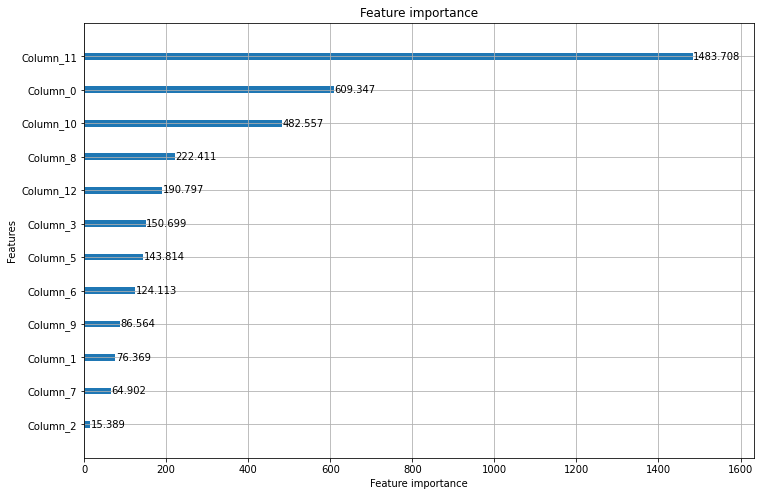

In [12]:
lightgbm.plot_importance(l2rRanker.model.ranker, figsize = (12,8))